In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load Data


In [2]:
champs = pd.read_csv("data_champs_elysee.csv", delimiter=";")
convention = pd.read_csv("data_convention.csv", delimiter=";")
st_peres = pd.read_csv("data_saints_peres.csv", delimiter=";")
print("len(champs):", len(champs))
print("len(convention):", len(convention))
print("len(st_peres):", len(st_peres))

len(champs): 9362
len(convention): 187000
len(st_peres): 37448


Let's filter data based on the entrance and exit nodes :

- **Champs-Elysées** : Noeud amont “Av_Champs_Elysees-Washington” et noeud aval “Av_Champs_Elysees-Berri”
- **Convention** : Noeud amont “Convention-Blomet” et noeud aval “Lecourbe-Convention”
- **Saints-Pères** : Noeud amont “Sts_Peres-Voltaire” et noeud aval “Sts_Peres-Universite”


In [3]:
champs = champs.loc[
    (champs["Libelle noeud amont"] == "Av_Champs_Elysees-Washington")
    & (champs["Libelle noeud aval"] == "Av_Champs_Elysees-Berri")
]

convention = convention.loc[
    (convention["Libelle noeud amont"] == "Convention-Blomet")
    & (convention["Libelle noeud aval"] == "Lecourbe-Convention")
]

st_peres = st_peres.loc[
    (st_peres["Libelle noeud amont"] == "Sts_Peres-Voltaire")
    & (st_peres["Libelle noeud aval"] == "Sts_Peres-Universite")
]

print("len(champs):", len(champs))
print("len(convention):", len(convention))
print("len(st_peres):", len(st_peres))

len(champs): 9362
len(convention): 9350
len(st_peres): 9362


## Process Data


Checking missing values :


In [4]:
print("champs.isnull().sum():", champs.isnull().sum())
print("convention.isnull().sum():", convention.isnull().sum())
print("st_peres.isnull().sum():", st_peres.isnull().sum())

champs.isnull().sum(): Identifiant arc                0
Libelle                        0
Date et heure de comptage      0
Débit horaire                267
Taux d'occupation            288
Etat trafic                    0
Identifiant noeud amont        0
Libelle noeud amont            0
Identifiant noeud aval         0
Libelle noeud aval             0
Etat arc                       0
Date debut dispo data          0
Date fin dispo data            0
geo_point_2d                   0
geo_shape                      0
dtype: int64
convention.isnull().sum(): Identifiant arc               0
Libelle                       0
Date et heure de comptage     0
Débit horaire                38
Taux d'occupation            35
Etat trafic                   0
Identifiant noeud amont       0
Libelle noeud amont           0
Identifiant noeud aval        0
Libelle noeud aval            0
Etat arc                      0
Date debut dispo data         0
Date fin dispo data           0
geo_point_2d              

We have ≈ 300 then 50 and 120 missing values for Champs-Elysées, Convention and Saints-Pères respectively. This is way less than the number of rows in the dataset, but let's see if these missing values are spread out or not. They could be related to a particular event.


In [5]:
champs["Date et heure de comptage"] = pd.to_datetime(
    champs["Date et heure de comptage"], utc=True
)
convention["Date et heure de comptage"] = pd.to_datetime(
    convention["Date et heure de comptage"], utc=True
)
st_peres["Date et heure de comptage"] = pd.to_datetime(
    st_peres["Date et heure de comptage"], utc=True
)

In [6]:
# Removing the UTC timezone from the datetime
champs["Date et heure de comptage"] = champs[
    "Date et heure de comptage"
].dt.tz_localize(None)

convention["Date et heure de comptage"] = convention[
    "Date et heure de comptage"
].dt.tz_localize(None)

st_peres["Date et heure de comptage"] = st_peres[
    "Date et heure de comptage"
].dt.tz_localize(None)

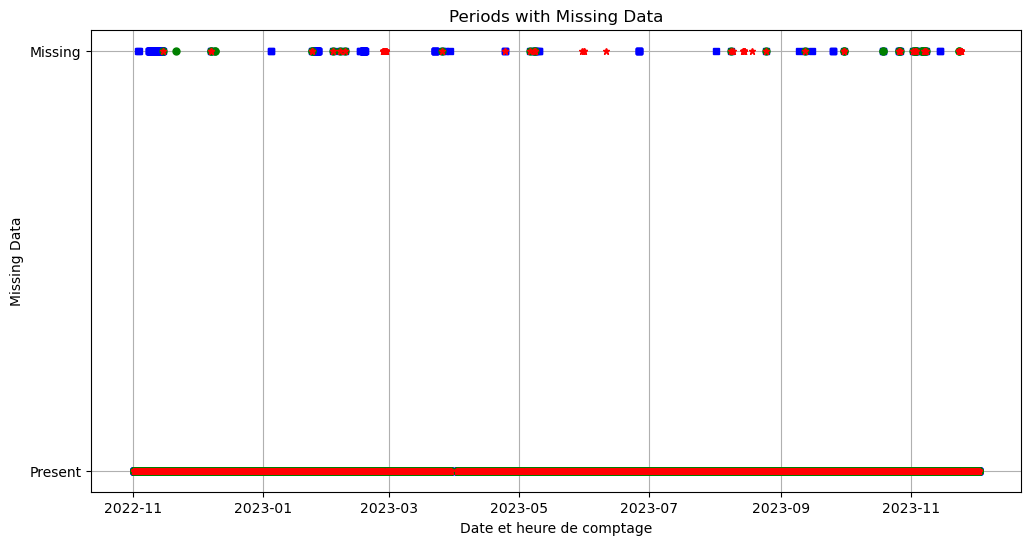

In [7]:
# Create a boolean mask where missing values are True
champs_missing = champs["Débit horaire"].isnull()
convention_missing = convention["Débit horaire"].isnull()
st_peres_missing = st_peres["Débit horaire"].isnull()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(
    champs["Date et heure de comptage"],
    champs_missing,
    marker="s",
    linestyle="None",
    markersize=5,
    color="blue",
)
plt.plot(
    convention["Date et heure de comptage"],
    convention_missing,
    marker="o",
    linestyle="None",
    markersize=5,
    color="green",
)
plt.plot(
    st_peres["Date et heure de comptage"],
    st_peres_missing,
    marker="*",
    linestyle="None",
    markersize=5,
    color="red",
)
plt.grid(True)
plt.title("Periods with Missing Data")
plt.xlabel("Date et heure de comptage")
plt.ylabel("Missing Data")
plt.yticks([0, 1], ["Present", "Missing"])
plt.show()

They are spread out, so we can't just drop them.


In [8]:
champs = champs.dropna()
convention = convention.dropna()
st_peres = st_peres.dropna()

Let's have an overview of the data now :


In [10]:
etat_trafic = {"Fluide": 1, "Pré-saturé": 2, "Saturé": 3, "Bloqué": 4, "Inconnu": 0}
etat_arc = {"Ouvert": 1, "Barré": 2, "Invalide": 3, "Inconnu": 0}

In [17]:
def plot_trafic_list(db_list, titles):
    fig, axes = plt.subplots(1, len(db_list), figsize=(20, 3 * len(db_list)))
    for i, db in enumerate(db_list):
        # Calculate the percentage of each "Etat trafic"
        etat_trafic_count = db["Etat trafic"].value_counts()
        etat_trafic_percent = etat_trafic_count / etat_trafic_count.sum()
        print("\n---- " + titles[i] + " ----")
        print(etat_trafic_percent)

        axes[i].scatter(
            db["Date et heure de comptage"],
            db["Débit horaire"],
            c=db["Etat trafic"].map(etat_trafic),
            s=10,
            cmap="magma",
        )
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Date et heure de comptage")
        axes[i].set_ylabel("Débit horaire")
        # reduce the font size of the x-axis tick labels
        axes[i].tick_params(axis="x", which="major", labelsize=8, rotation=45)
        axes[i].grid(True)
    plt.show()


---- Champs Elysee ----
Pré-saturé    0.471236
Fluide        0.409742
Saturé        0.084307
Bloqué        0.034715
Name: Etat trafic, dtype: float64

---- Convention ----
Fluide        0.998067
Pré-saturé    0.001933
Name: Etat trafic, dtype: float64

---- Saints Peres ----
Fluide        0.965417
Pré-saturé    0.032746
Saturé        0.001837
Name: Etat trafic, dtype: float64


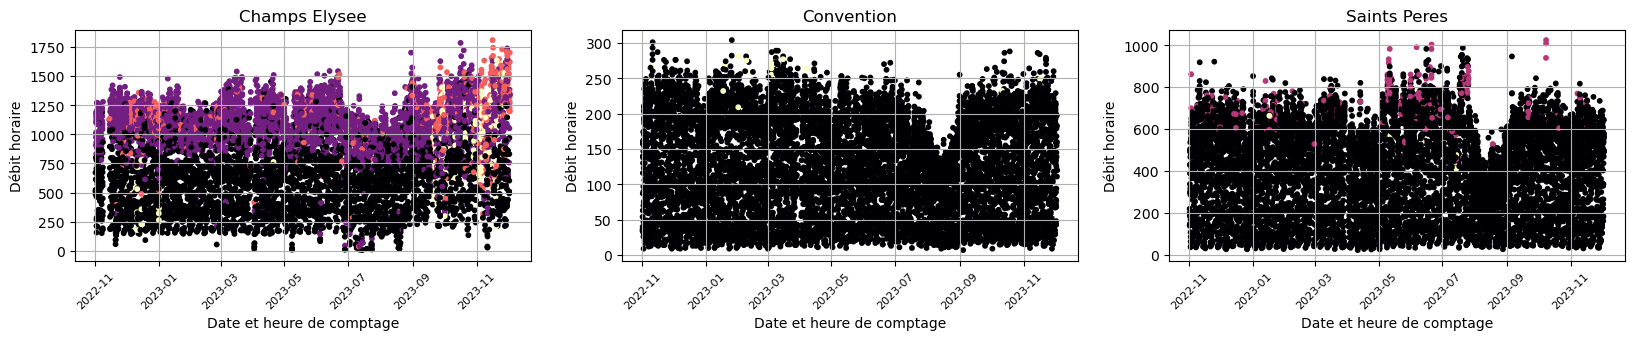

In [15]:
db_list = [champs, convention, st_peres]
titles = ["Champs Elysee", "Convention", "Saints Peres"]
plot_trafic_list(db_list, titles)

Our focus is to forecast for the dates from 08/12 to 12/12. Therefore, let's have a more precise look at the data in december for each year :



---- Champs Elysee ----
Fluide        0.414986
Pré-saturé    0.350144
Saturé        0.197406
Bloqué        0.037464
Name: Etat trafic, dtype: float64

---- Convention ----
Fluide    1.0
Name: Etat trafic, dtype: float64

---- Saints Peres ----
Fluide        0.982684
Pré-saturé    0.017316
Name: Etat trafic, dtype: float64


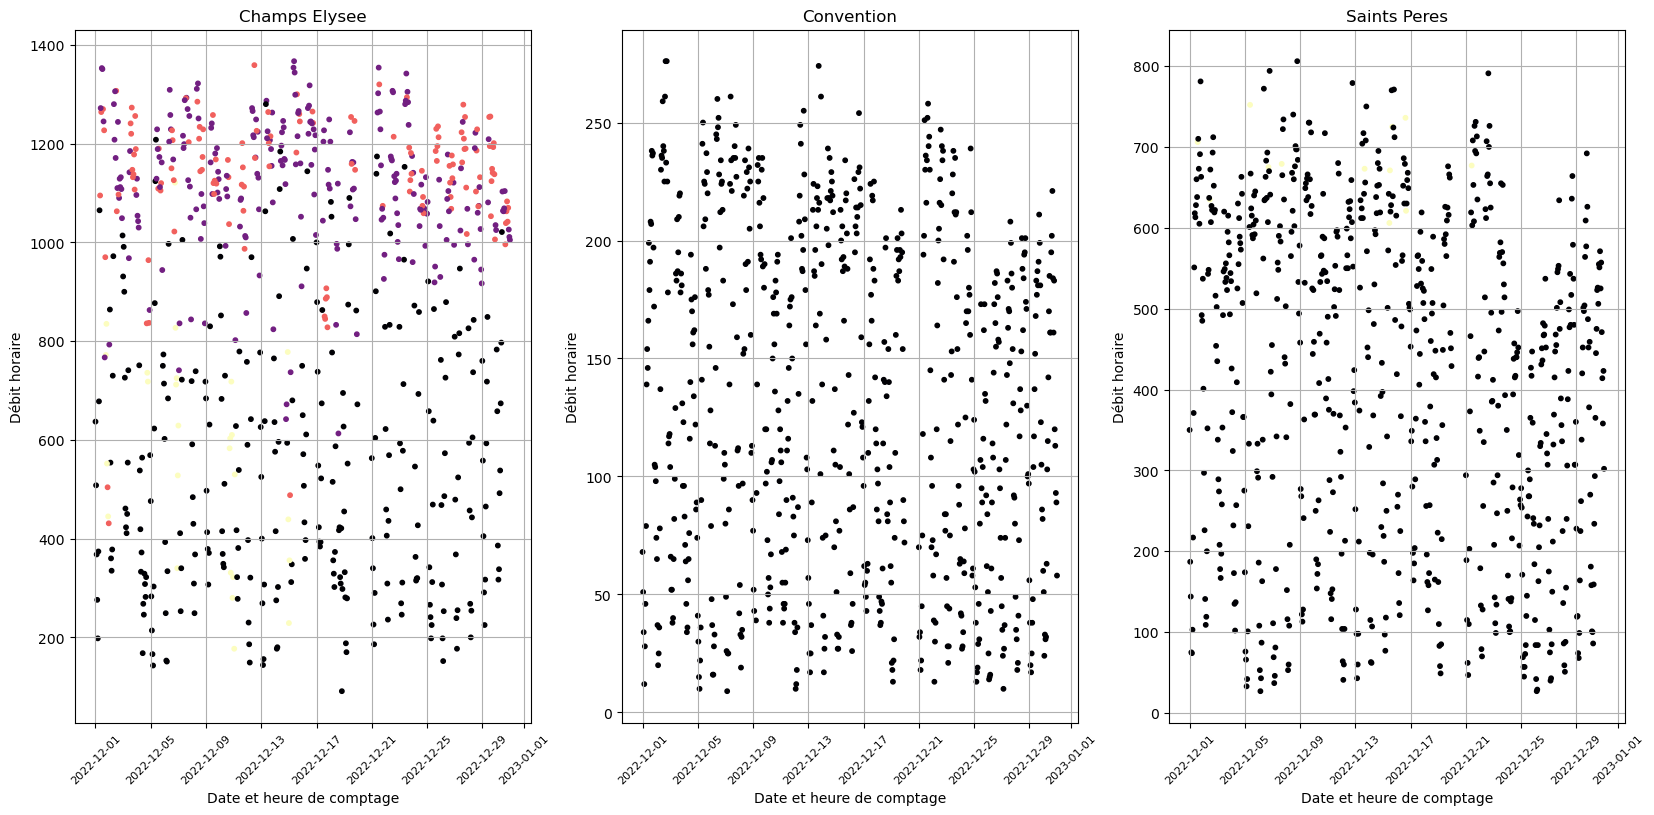

In [18]:
# Plot for december
dec_start = pd.to_datetime("2022-12-01")
dec_end = pd.to_datetime("2022-12-31")

champs_december = champs.loc[
    (champs["Date et heure de comptage"] >= dec_start)
    & (champs["Date et heure de comptage"] <= dec_end)
]

convention_december = convention.loc[
    (convention["Date et heure de comptage"] >= dec_start)
    & (convention["Date et heure de comptage"] <= dec_end)
]

st_peres_december = st_peres.loc[
    (st_peres["Date et heure de comptage"] >= dec_start)
    & (st_peres["Date et heure de comptage"] <= dec_end)
]

db_list_december = [champs_december, convention_december, st_peres_december]

plot_trafic_list(db_list_december, titles)

Let's just do a Xgboost model for now, and we'll see if we can improve it later on.


In [22]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [24]:
# Let's create a RNN with 2 LSTM layers in order to predict the traffic flow


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(
            self.input_dim, self.hidden_dim, self.num_layers, batch_first=True
        )

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
        )

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))

        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [30]:
champs.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
0,4264,AV_Champs_Elysees,2023-02-01 22:00:00,764.0,11.28000,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
1,4264,AV_Champs_Elysees,2023-02-01 21:00:00,819.0,16.52056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
2,4264,AV_Champs_Elysees,2023-02-01 19:00:00,1082.0,19.98722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
3,4264,AV_Champs_Elysees,2023-02-01 17:00:00,1027.0,23.27334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
4,4264,AV_Champs_Elysees,2022-12-06 23:00:00,528.0,68.14334,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."


In [40]:
# Let's prepare the data. First, we will split the column 'Date et heure de comptage' into two columns: 'Year', 'Month', 'Day', 'Hour' and then delete the column 'Date et heure de comptage'
# We will also remove the columns 'Libelle noeud amont', 'Libelle noeud aval', 'Libelle', 'Identifiant arc', 'Date debut dispo data' and 'Date fin dispo data' because they are not useful for the prediction


# Let's create a function that will generalize the data preparation for all the dataframes
def prepare_data(df):
    df_data = pd.DataFrame(
        data={
            "Etat trafic": df["Etat trafic"],
            "Débit horaire": df["Débit horaire"],
            "Taux d'occupation": df["Taux d'occupation"],
        }
    )
    df_data["Year"] = df["Date et heure de comptage"].dt.year
    df_data["Month"] = df["Date et heure de comptage"].dt.month
    df_data["Day"] = df["Date et heure de comptage"].dt.day
    df_data["Hour"] = df["Date et heure de comptage"].dt.hour
    df_data["Etat trafic"] = df_data["Etat trafic"].map(etat_trafic)
    return df_data


df_champs = prepare_data(champs)
df_conv = prepare_data(convention)
df_pere = prepare_data(st_peres)

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03

At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


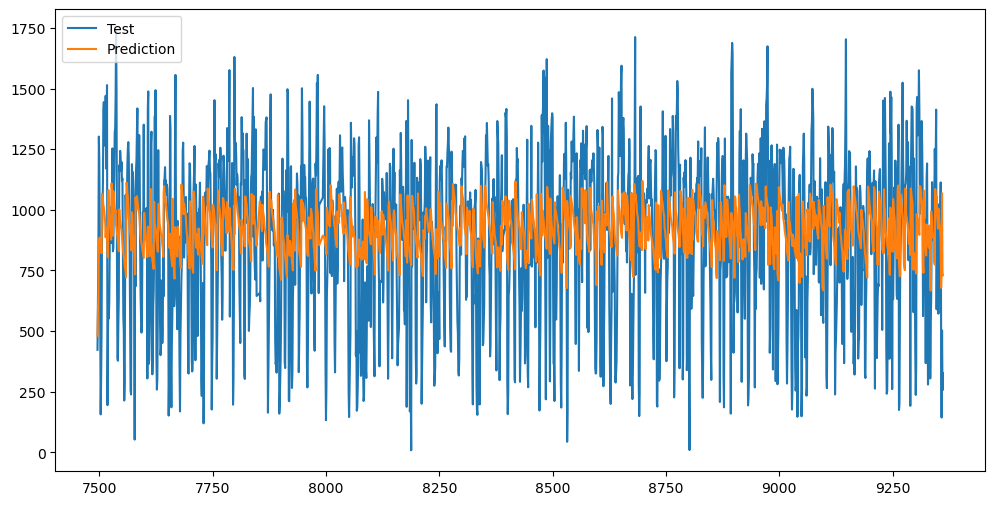

In [52]:
# Let's use Seasonal Autoregressive Integrated Moving Average (SARIMA) to predict the traffic flow
# We will use the library statsmodels to do that
# We will use the function SARIMAX to predict the traffic flow
# SARIMAX is an extension of the SARIMA model that also includes exogenous variables (exogenous variables are external variables that affect the time series but are not affected by it)
# Example of exogenous variables: the weather, the day of the week, the month, the year, etc.
# We will use the columns 'Year', 'Month', 'Day', 'Hour' as exogenous variables
# We will use the column 'Etat trafic' as endogenous variable
# We will use the column 'Débit horaire' as endogenous variable
# We will use the column 'Taux d'occupation' as endogenous variable


# Let's create a function that will generalize the SARIMAX model for all the dataframes
def sarimax_model(df, n):
    # Let's split the data into train and test sets
    train = df[: int(0.8 * len(df))]
    test = df[int(0.8 * len(df)) :]

    # Let's create the exogenous variable
    exog_train = train[["Year", "Month", "Day", "Hour"]]
    exog_test = test[["Year", "Month", "Day", "Hour"]]

    # Let's create the endogenous variable
    endog_train = train["Débit horaire"]
    endog_test = test["Débit horaire"]

    # Let's fit the model
    model = SARIMAX(endog=endog_train, exog=exog_train, order=(1, 0, 0), trend_offset=n)
    model_fit = model.fit()

    # Let's make the prediction
    y_pred = model_fit.predict(
        start=len(endog_train),
        end=len(endog_train) + len(endog_test) - 1,
        exog=exog_test,
    )

    # Let's calculate the mean squared error
    mse = mean_squared_error(endog_test, y_pred)
    print("MSE: ", mse)

    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    # Let's calculate the mean absolute error
    mae = mean_absolute_error(endog_test, y_pred)
    print("MAE: ", mae)

    # Let's calculate the R2 score
    r2 = r2_score(endog_test, y_pred)
    print("R2: ", r2)

    # Let's plot the prediction
    plt.figure(figsize=(12, 6))
    plt.plot(endog_test.index, endog_test, label="Test")
    plt.plot(endog_test.index, y_pred, label="Prediction")
    plt.legend(loc="upper left")
    plt.show()

    return model_fit, mse, mae, r2


model_champs, mse_champs, mae_champs, r2_champs = sarimax_model(df_champs, 3)

i = 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


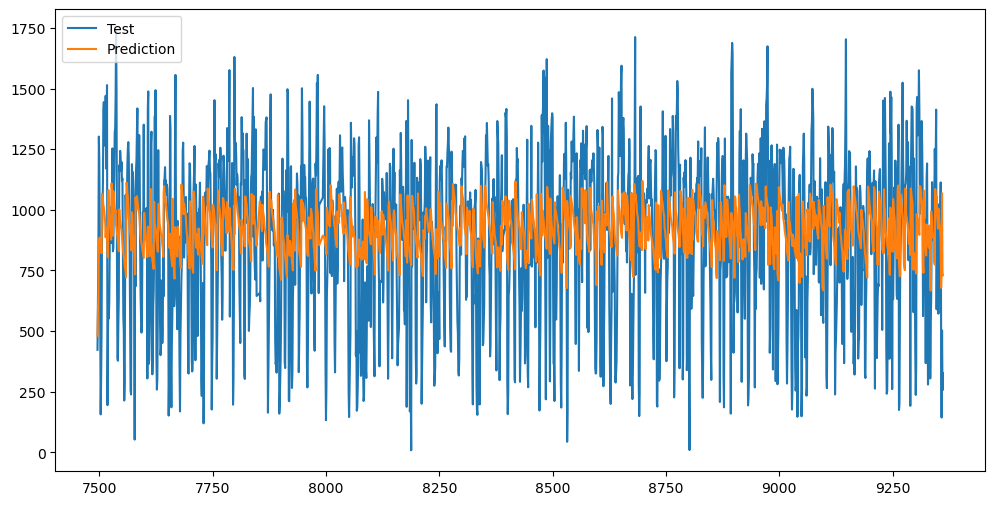

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


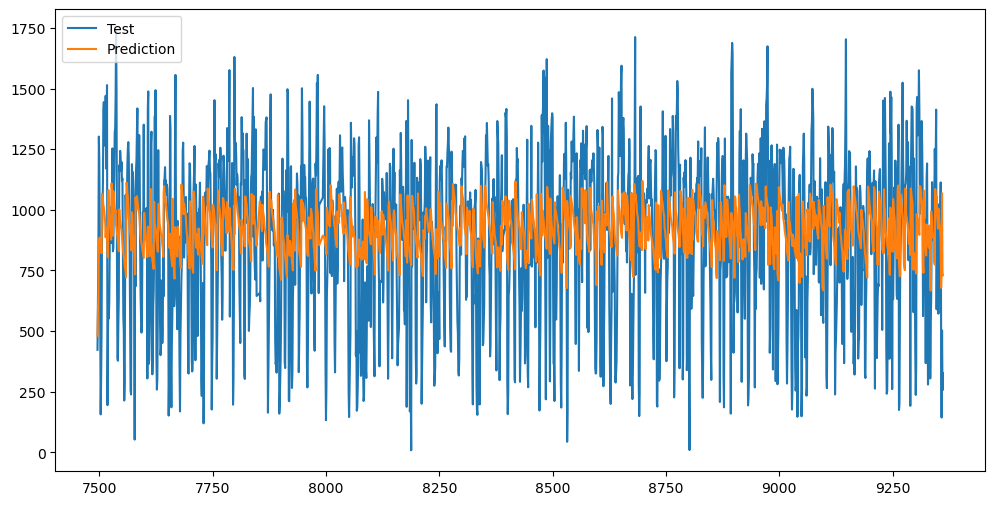

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


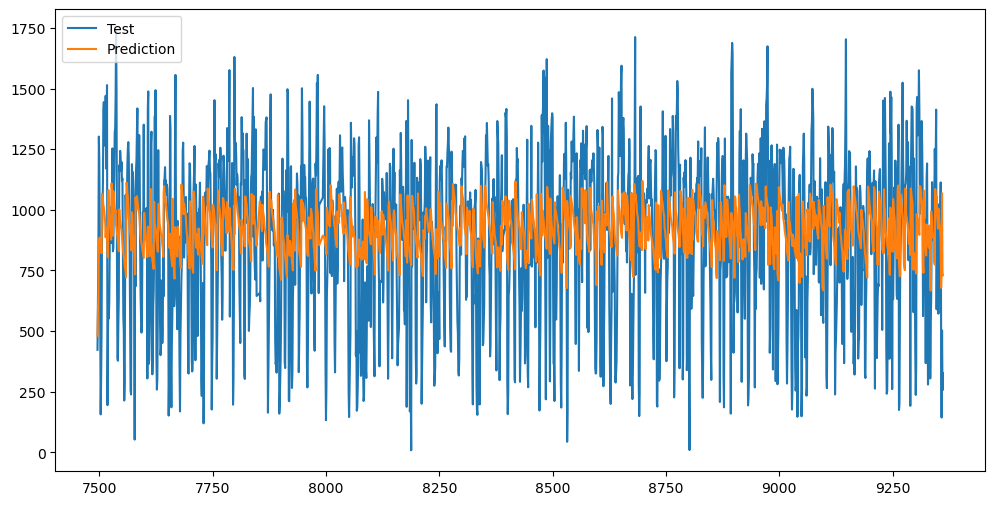

i = 4


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03

At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


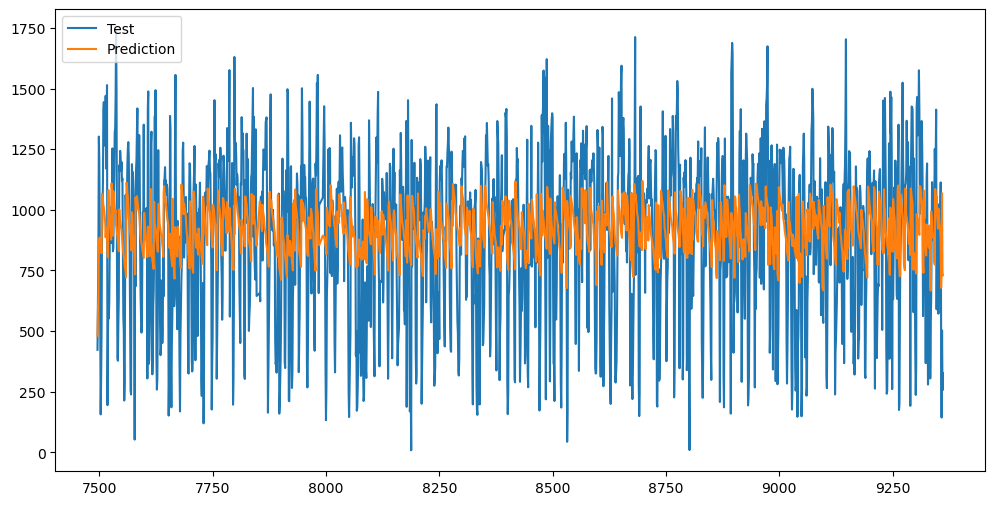

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


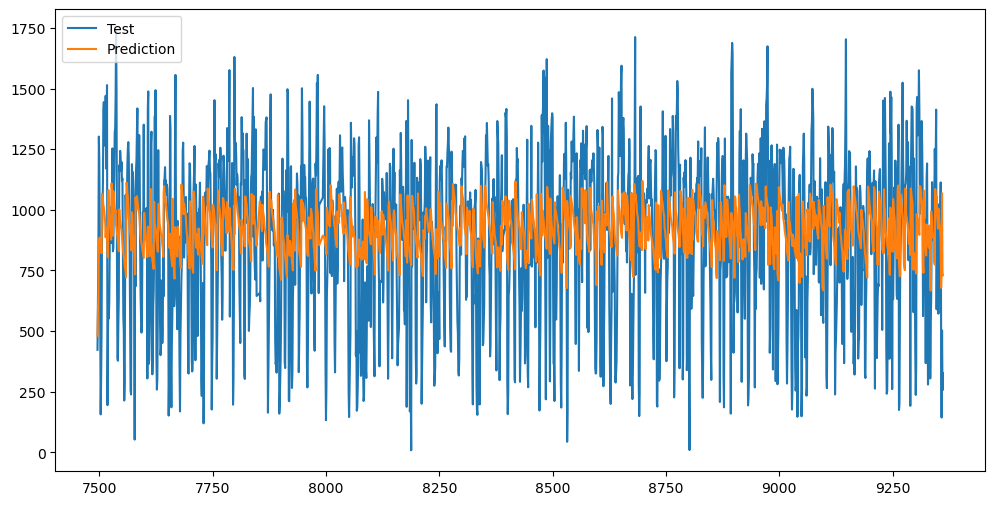

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


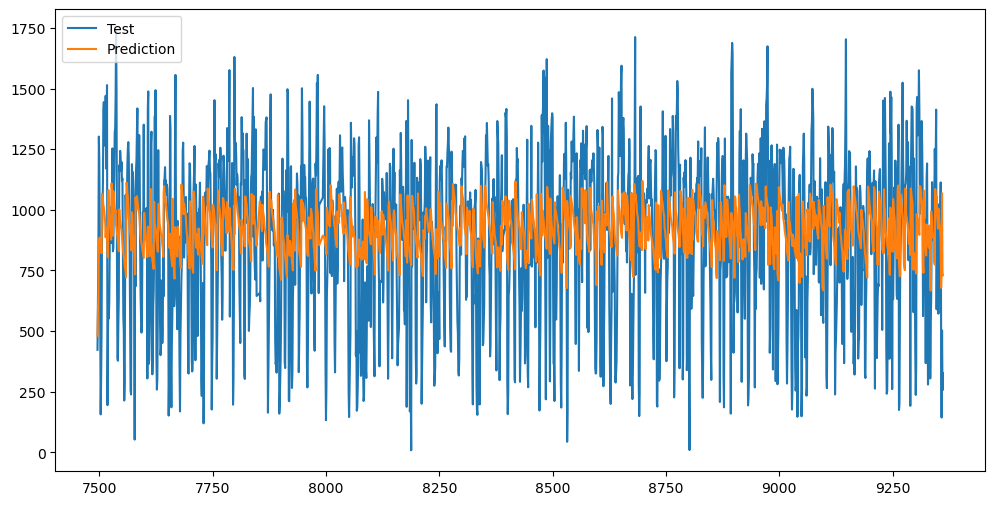

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


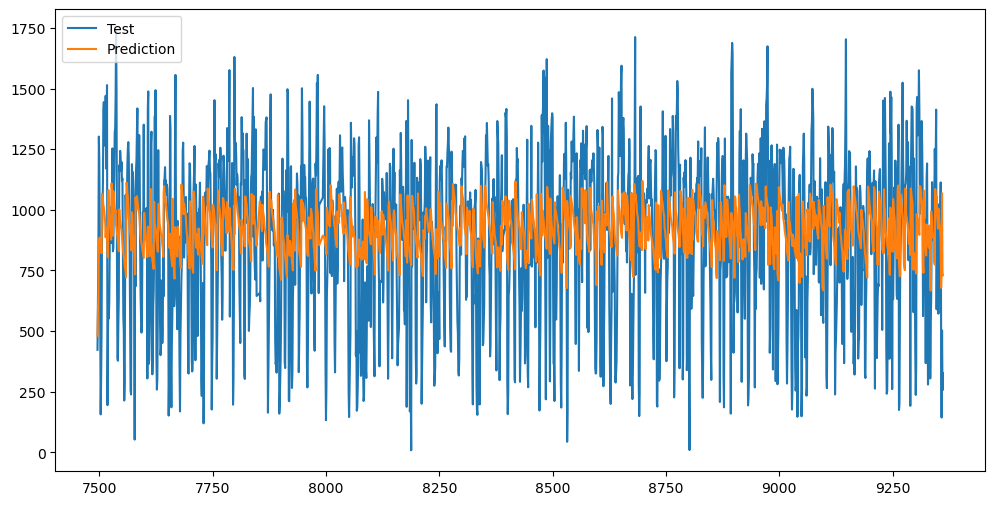

/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


i = 8
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


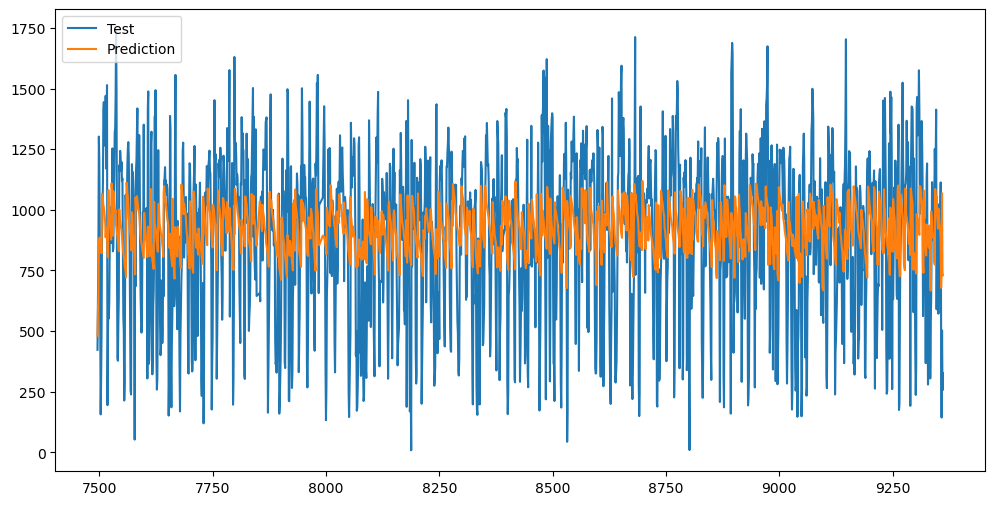

i = 9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98070D+00    |proj g|=  3.74103D-03


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.



At iterate    5    f=  6.96372D+00    |proj g|=  7.32636D-04

At iterate   10    f=  6.96367D+00    |proj g|=  5.29611D-03

At iterate   15    f=  6.96299D+00    |proj g|=  1.30825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     25      1     0     0   6.344D-05   6.963D+00
  F =   6.9629901099574356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE:  95689.6718443641
RMSE:  309.3374724218909
MAE:  253.8131490062386
R2:  0.1753075583000795


/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ilyess/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['verbose']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


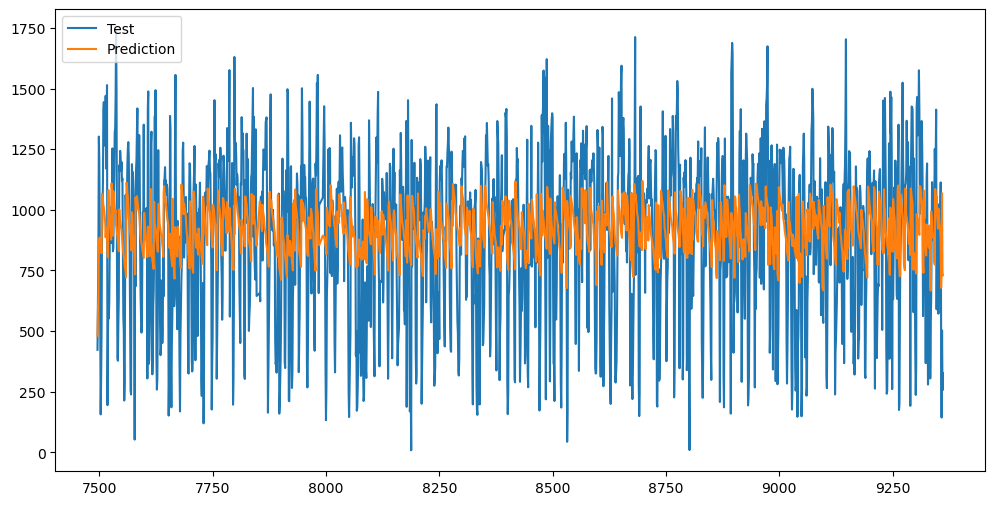

In [53]:
for i in range(1, 10):
    print("i =", i)
    model_champs, mse_champs, mae_champs, r2_champs = sarimax_model(df_champs, i)